# Python数据科学分享系列——2.数据处理


- toc: true 
- badges: true
- comments: true
- categories: [jupyter,Python]

![](2.data-elt/markmap.png)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn

seaborn.set()
plt.rcParams["font.sans-serif"] = ["SimHei"]
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm.notebook import tqdm

<img src="2.data-elt/data2info.png" width=500px></img>

<img src="2.data-elt/data_type.png" width=500px></img>

<center>python数值计算历史</center>


| 首发年份 | 名称 | 场景 |
| :-: | :-: | :-: |
| 1991 | Python |  编程语言  |
| 2001 | ipython | 增强shell   |
| 2001 | SciPy | 算法库   |
| 2006 | Numpy | 数组运算   |
| 2007 | Cython | AOT静态编译   |
| 2008 | Pandas | 标签数组运算     |
| 2010 | scikit-learn | 机器学习   |
| 2012 | ipython notebook | 计算环境   |
| 2012 | anaconda | 管理工具   |
| 2012 | Numba | llvm实现JIT编译器 |
| 2012 | pyspark | 集群运算 |
| 2015 | jupyter | 多语言支持 |
| 2015 | TensorFlow | 深度学习 |

<center>With great power comes great complexity（越强大越复杂）</center>

# Numpy

## 神经网络示例

### 背景

In [2]:
from IPython.display import Video

# https://github.com/Sentdex/NNfSiX

Video("cat_neural_network.mp4")

| x1| x2| x3| Y |
| :-:| :-:| :-:| :-: |
| 0| 0| 1| 0 |
| 0| 1| 1| 1 |
| 1| 0| 1| 1 |
| 1| 1| 1| 0 |

In [3]:
X = np.array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
y = np.array([[0], [1], [1], [0]])

### 网络图

<img src="2.data-elt/two_layer_nn.png" width=500px></img>

### 数学描述

公式1 $$ \hat y = \sigma(W_2\sigma(W_1x+ b_1) + b_2) $$

公式2（sigmoid） $$ \sigma = \frac {1} {1 + e^{-x}} $$

公式3（sigmoid导数） $$ \sigma' = \sigma(x) \times (1 - \sigma(x)) $$

![](sigmoid.png)

### 反向传播

![](nn_flow.png)

公式4 $$ Loss(Sum\ of\ Squares\ Error) = \sum_{i=1}^n(y-\hat y)^2 $$

### numpy实现

In [4]:
def σ(x):
    return 1 / (1 + np.exp(-x))


def σ_dvt(x):
    return σ(x) * (1 - σ(x))


class NeuralNetwork(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.w1 = np.random.rand(self.x.shape[1], 4)
        self.w2 = np.random.rand(4, 1)
        self.yhat = np.zeros(self.y.shape)

    def feedforward(self):
        self.layer1 = σ(self.x @ self.w1)
        self.yhat = σ(self.layer1 @ self.w2)

    def backprop(self):
        gd = 2 * (self.y - self.yhat) * σ_dvt(self.yhat)
        d_w2 = self.layer1.T @ gd
        d_w1 = self.x.T @ (gd @ (self.w2.T) * σ_dvt(self.layer1))

        self.w1 += d_w1
        self.w2 += d_w2

In [5]:
nn = NeuralNetwork(X, y)

train = []
for i in tqdm(range(10000)):
    nn.feedforward()
    nn.backprop()
    loss = sum((_[0] - _[1])[0] ** 2 for _ in zip(nn.y, nn.yhat))
    train.append(loss)

print(nn.yhat)


[[0.00644673]
 [0.9909493 ]
 [0.99080728]
 [0.00803459]]


In [11]:
def show_plot(x, y):
    plt.figure(figsize=(15, 5))
    plt.plot(
        x,
        y,
        linewidth=3,
        linestyle=":",
        color="blue",
        label="Sum of Squares Error",
    )
    plt.xlabel("训练次数")
    plt.ylabel("训练损失")
    plt.title("训练损失随次数增加而递减")
    plt.legend(loc="upper right")
    plt.show()

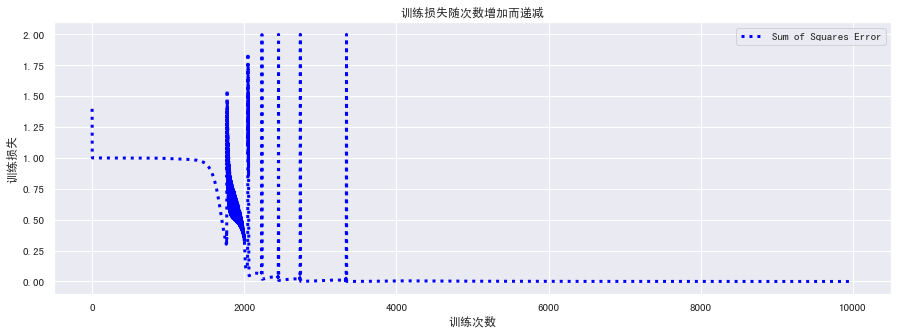

In [12]:
show_plot(range(len(train)), train)

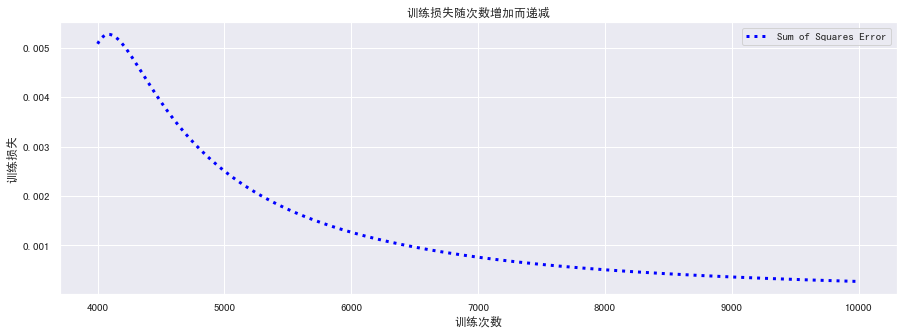

In [13]:
show_plot(range(4000, len(train)), train[4000:])

## 数据结构

NumPy在C语言的基础上开发`ndarray`对象，其数据类型也是在C语言基础上进行扩充。

CPython的整型对象是一个PyObject_HEAD是C语言结构体，包含引用计数、类型编码和数据大小等信息，相比C语言的整型增加了很多开销，Numpy进行了优化。

<img src="https://raw.githubusercontent.com/muxuezi/pdsh/master/images/pyds_02in02.png" width=500px></img>

## 数组初始化

In [14]:
# 创建一个长度为10的数组，数组的值都是0
np.zeros(10, dtype=int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
# 创建一个3x5的浮点型数组，数组的值都是1
np.ones((3, 5), dtype=float)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [16]:
# 创建一个3x5的浮点型数组，数组的值都是3.14
np.full((3, 5), 3.14)

array([[3.14, 3.14, 3.14, 3.14, 3.14],
       [3.14, 3.14, 3.14, 3.14, 3.14],
       [3.14, 3.14, 3.14, 3.14, 3.14]])

In [17]:
# 创建一个线性序列数组，从0开始，到20结束，步长为2（它和内置的range()函数类似）
np.arange(0, 20, 2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [18]:
# 创建一个5个元素的数组，这5个数均匀地分配到0~1区间
np.linspace(0, 1, 5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [19]:
# NumPy的随机数生成器设置一组种子值，以确保每次程序执行时都可以生成同样的随机数组：
np.random.seed(1024)

# 创建一个3x3的、0~1之间均匀分布的随机数组成的数组
np.random.random((3, 3))

array([[0.64769123, 0.99691358, 0.51880326],
       [0.65811273, 0.59906347, 0.75306733],
       [0.13624713, 0.00411712, 0.14950888]])

In [20]:
# 创建一个3x3的、均值为0、标准差为1的正态分布的随机数数组
np.random.normal(0, 1, (3, 3))

array([[ 0.7729004 ,  1.64294992, -0.12721717],
       [ 0.91598327,  0.52267255, -0.22634267],
       [ 1.41873344, -0.16232799,  0.53831355]])

In [21]:
# 创建一个3x3的、[0, 10)区间的随机整型数组
np.random.randint(0, 10, (3, 3))

array([[6, 4, 4],
       [1, 0, 1],
       [8, 7, 0]])

In [22]:
# 创建一个3x3的单位矩阵
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [23]:
# 创建一个由3个整型数组成的未初始化的数组，数组的值是内存空间中的任意值
np.empty(3)

array([1., 1., 1.])

1. 属性：确定数组的大小、形状、存储大小、数据类型
1. 读写：数组保存与加载文件
1. 数学运算：加减乘除、指数与平方根、三角函数、聚合比较等基本运算
1. 复制与排序：数组深浅copy、快速排序、归并排序和堆排序
1. 索引：获取和设置数组各个元素的值
1. 切分：在数组中获取或设置子数组
1. 变形：改变给定数组的形状
1. 连接和分裂：将多个数组合并为一个，或者将一个数组分裂成多个

![](numpy.png)

## 通用函数(universal functions, ufunc)

NumPy实现一种静态类型、可编译程序接口（**ufunc**），实现**向量化(vectorize)**操作，避免for循环，提高效率，节约内存。

通用函数有两种存在形式：

1. **一元通用函数**（unary ufunc）对单个输入操作
2. **二元通用函数**（binary ufunc）对两个输入操作

### 数组的运算

NumPy通用函数的使用方式非常自然，因为它用到了Python原生的算术运算符(加、减、乘、除)、绝对值、三角函数、指数与对数、布尔/位运算符。

运算符 | 对应的通用函数 | 描述  
---|---|---  
`+` | `np.add` | 加法运算（即`1 + 1 = 2`） 
`-` | `np.subtract` | 减法运算（即`3 - 2 = 1`）
`-` | `np.negative` | 负数运算 （即`-2`）
`*` | `np.multiply` | 乘法运算 （即`2 * 3 = 6`）
`/` | `np.divide` | 除法运算 （即`3 / 2 = 1.5`）
`//` | `np.floor_divide` | 地板除法运算（floor division，即`3 // 2 = 1`）
`**` | `np.power` | 指数运算 （即`2 ** 3 = 8`）
`%` | `np.mod` | 模/余数 （即`9 % 4 = 1`）
|`np.abs`|绝对值

In [24]:
x = np.arange(4)
print("x     =", x)
print("x + 5 =", x + 5)
print("x - 5 =", x - 5)
print("x * 2 =", x * 2)
print("x / 2 =", x / 2)
print("x // 2 =", x // 2)  # 整除运算

x     = [0 1 2 3]
x + 5 = [5 6 7 8]
x - 5 = [-5 -4 -3 -2]
x * 2 = [0 2 4 6]
x / 2 = [0.  0.5 1.  1.5]
x // 2 = [0 0 1 1]


In [25]:
x = [1, 2, 3]
print("x     =", x)
print("e^x   =", np.exp(x))
print("2^x   =", np.exp2(x))
print("3^x   =", np.power(3, x))
print("x        =", x)
print("ln(x)    =", np.log(x))
print("log2(x)  =", np.log2(x))
print("log10(x) =", np.log10(x))

x     = [1, 2, 3]
e^x   = [ 2.71828183  7.3890561  20.08553692]
2^x   = [2. 4. 8.]
3^x   = [ 3  9 27]
x        = [1, 2, 3]
ln(x)    = [0.         0.69314718 1.09861229]
log2(x)  = [0.        1.        1.5849625]
log10(x) = [0.         0.30103    0.47712125]


### 特殊ufunc

`scipy.special`提供了大量统计学函数。例如，Γ函数和β函数

In [26]:
from scipy import special

x = [1, 5, 10]
print("gamma(x)     =", special.gamma(x))
print("ln|gamma(x)| =", special.gammaln(x))
print("beta(x, 2)   =", special.beta(x, 2))

gamma(x)     = [1.0000e+00 2.4000e+01 3.6288e+05]
ln|gamma(x)| = [ 0.          3.17805383 12.80182748]
beta(x, 2)   = [0.5        0.03333333 0.00909091]


### 高级特性

### 累计

二元通用函数的`reduce`方法可以对给定元素和操作重复执行，直至得到一个汇总结果。`accumulate`方法实现截至每一个元素的累积结果

例如，对`add`通用函数调用`reduce`方法会返回数组中所有元素的和：

In [27]:
x = np.arange(1, 6)
np.add.reduce(x)

15

同样，对`multiply`通用函数调用`reduce`方法会返回数组中所有元素的乘积：

In [28]:
np.multiply.reduce(x)   

120

In [29]:
np.add.accumulate(x) 

array([ 1,  3,  6, 10, 15])

In [30]:
np.multiply.accumulate(x)

array([  1,   2,   6,  24, 120])

> NumPy提供了专用的函数（`np.sum`、`np.prod`、`np.cumsum`、`np.cumprod` ），它们也可以实现`reduce`的功能


### 外积

任何通用函数都可以用`outer`方法获得两个不同输入数组所有元素对的函数运算结果。用一行代码实现一个99乘法表：

In [31]:
x = np.arange(1, 10)
np.multiply.outer(x, x)

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 2,  4,  6,  8, 10, 12, 14, 16, 18],
       [ 3,  6,  9, 12, 15, 18, 21, 24, 27],
       [ 4,  8, 12, 16, 20, 24, 28, 32, 36],
       [ 5, 10, 15, 20, 25, 30, 35, 40, 45],
       [ 6, 12, 18, 24, 30, 36, 42, 48, 54],
       [ 7, 14, 21, 28, 35, 42, 49, 56, 63],
       [ 8, 16, 24, 32, 40, 48, 56, 64, 72],
       [ 9, 18, 27, 36, 45, 54, 63, 72, 81]])

## 广播(Broadcasting)

NumPy也可以通过广播实现向量化操作。广播可以用于不同大小数组的二元通用函数（加、减、乘等）的一组规则:
  * 规则1：如果两个数组的维度数不相同，那么小维度数组的形状将会在最左边补1。
  * 规则2：如果两个数组的形状在任何一个维度上都不匹配，那么数组的形状会沿着维度为1的维度扩展以匹配另外一个数组的形状。
  * 规则3：如果两个数组的形状在任何一个维度上都不匹配并且没有任何一个维度等于1，那么会引发异常。

In [32]:
a = np.arange(3)
a + 5

array([5, 6, 7])

In [33]:
np.ones((3, 3)) + a

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

根据规则1，数组`a`的维度数更小，所以在其左边补1：


   `b.shape -> (3, 3)`
   
   `a.shape -> (1, 3)`

根据规则2，第一个维度不匹配，因此扩展这个维度以匹配数组：


   `b.shape -> (3, 3)`
   
   `a.shape -> (3, 3)`

现在两个数组的形状匹配了，可以看到它们的最终形状都为`(3, 3)`：

In [34]:
b = np.arange(3)[:, np.newaxis] 

b + a

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

根据规则1，数组`a`的维度数更小，所以在其左边补1：


   `b.shape -> (3, 1)`
   
   `a.shape -> (1, 3)`

根据规则2，两个维度都不匹配，因此扩展这个维度以匹配数组：


   `b.shape -> (3, 3)`
   
   `a.shape -> (3, 3)`

现在两个数组的形状匹配了，可以看到它们的最终形状都为`(3, 3)`：

![](https://raw.githubusercontent.com/muxuezi/pdsh/master/images/pyds_02in04.png)

# Scipy稀疏矩阵

地球70多亿人的社交网络中，大部分人直接认识的人数不超过10000，因此这个矩阵中，大部分的值都是0（稀疏）

<img src="2.data-elt/social_network.jpg" width=500px></img>

In [35]:
SN = np.random.poisson(0.2, (10, 10)) * np.random.randint(0, 10, (10, 10))
SN

array([[ 8,  0,  0,  0,  9,  0,  0,  0,  0,  3],
       [ 0,  0,  9,  0,  7,  0,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  4,  0,  0],
       [ 0,  5,  0,  0,  0,  7,  0,  0,  0,  0],
       [ 0,  8,  8,  1,  0,  1,  4,  0,  0,  0],
       [ 0, 18,  0,  0,  0,  0,  0,  0,  0,  4],
       [ 0,  0,  4,  0,  0,  0,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  4,  0,  0,  0]])

In [36]:
rows, cols = np.nonzero(SN)
vals = SN[rows, cols]
rows, cols, vals

(array([0, 0, 0, 1, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 6, 6, 7, 7, 8, 9,
        9]),
 array([0, 4, 9, 2, 4, 9, 8, 3, 7, 1, 5, 1, 2, 3, 5, 6, 1, 9, 2, 6, 4, 3,
        6]),
 array([ 8,  9,  3,  9,  7,  4,  8,  9,  4,  5,  7,  8,  8,  1,  1,  4, 18,
         4,  4,  5,  5,  9,  4]))

## 稀疏矩阵初始化

In [37]:
X = sparse.coo_matrix(SN)
X

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 23 stored elements in COOrdinate format>

In [38]:
print(X)

  (0, 0)	8
  (0, 4)	9
  (0, 9)	3
  (1, 2)	9
  (1, 4)	7
  (1, 9)	4
  (2, 8)	8
  (3, 3)	9
  (3, 7)	4
  (4, 1)	5
  (4, 5)	7
  (5, 1)	8
  (5, 2)	8
  (5, 3)	1
  (5, 5)	1
  (5, 6)	4
  (6, 1)	18
  (6, 9)	4
  (7, 2)	4
  (7, 6)	5
  (8, 4)	5
  (9, 3)	9
  (9, 6)	4


## 按坐标创建稀疏矩阵

In [39]:
X2 = sparse.coo_matrix((vals, (rows, cols)))

In [40]:
X2.todense()

matrix([[ 8,  0,  0,  0,  9,  0,  0,  0,  0,  3],
        [ 0,  0,  9,  0,  7,  0,  0,  0,  0,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  0],
        [ 0,  0,  0,  9,  0,  0,  0,  4,  0,  0],
        [ 0,  5,  0,  0,  0,  7,  0,  0,  0,  0],
        [ 0,  8,  8,  1,  0,  1,  4,  0,  0,  0],
        [ 0, 18,  0,  0,  0,  0,  0,  0,  0,  4],
        [ 0,  0,  4,  0,  0,  0,  5,  0,  0,  0],
        [ 0,  0,  0,  0,  5,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  9,  0,  0,  4,  0,  0,  0]])

## 数据压缩

将稀疏矩阵保存为 CSR(Compressed Sparse Row)/CSC(Compressed Sparse Column) 格式

In [41]:
np.vstack([rows, cols])

array([[0, 0, 0, 1, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 6, 6, 7, 7, 8, 9,
        9],
       [0, 4, 9, 2, 4, 9, 8, 3, 7, 1, 5, 1, 2, 3, 5, 6, 1, 9, 2, 6, 4, 3,
        6]])

In [42]:
indptr = np.r_[np.searchsorted(rows, np.unique(rows)), len(rows)]
indptr

array([ 0,  3,  6,  7,  9, 11, 16, 18, 20, 21, 23])

In [43]:
X3 = sparse.csr_matrix((vals, cols, indptr))
X3

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 23 stored elements in Compressed Sparse Row format>

In [44]:
print(X3)

  (0, 0)	8
  (0, 4)	9
  (0, 9)	3
  (1, 2)	9
  (1, 4)	7
  (1, 9)	4
  (2, 8)	8
  (3, 3)	9
  (3, 7)	4
  (4, 1)	5
  (4, 5)	7
  (5, 1)	8
  (5, 2)	8
  (5, 3)	1
  (5, 5)	1
  (5, 6)	4
  (6, 1)	18
  (6, 9)	4
  (7, 2)	4
  (7, 6)	5
  (8, 4)	5
  (9, 3)	9
  (9, 6)	4


In [45]:
X3.todense()

matrix([[ 8,  0,  0,  0,  9,  0,  0,  0,  0,  3],
        [ 0,  0,  9,  0,  7,  0,  0,  0,  0,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  0],
        [ 0,  0,  0,  9,  0,  0,  0,  4,  0,  0],
        [ 0,  5,  0,  0,  0,  7,  0,  0,  0,  0],
        [ 0,  8,  8,  1,  0,  1,  4,  0,  0,  0],
        [ 0, 18,  0,  0,  0,  0,  0,  0,  0,  4],
        [ 0,  0,  4,  0,  0,  0,  5,  0,  0,  0],
        [ 0,  0,  0,  0,  5,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  9,  0,  0,  4,  0,  0,  0]])

In [46]:
X4 = X2.tocsr()

X4

<10x10 sparse matrix of type '<class 'numpy.longlong'>'
	with 23 stored elements in Compressed Sparse Row format>

In [47]:
print(X4)

  (0, 0)	8
  (0, 4)	9
  (0, 9)	3
  (1, 2)	9
  (1, 4)	7
  (1, 9)	4
  (2, 8)	8
  (3, 3)	9
  (3, 7)	4
  (4, 1)	5
  (4, 5)	7
  (5, 1)	8
  (5, 2)	8
  (5, 3)	1
  (5, 5)	1
  (5, 6)	4
  (6, 1)	18
  (6, 9)	4
  (7, 2)	4
  (7, 6)	5
  (8, 4)	5
  (9, 3)	9
  (9, 6)	4


In [48]:
X5 = X2.tocsc()

X5

<10x10 sparse matrix of type '<class 'numpy.longlong'>'
	with 23 stored elements in Compressed Sparse Column format>

In [49]:
print(X5)

  (0, 0)	8
  (4, 1)	5
  (5, 1)	8
  (6, 1)	18
  (1, 2)	9
  (5, 2)	8
  (7, 2)	4
  (3, 3)	9
  (5, 3)	1
  (9, 3)	9
  (0, 4)	9
  (1, 4)	7
  (8, 4)	5
  (4, 5)	7
  (5, 5)	1
  (5, 6)	4
  (7, 6)	5
  (9, 6)	4
  (3, 7)	4
  (2, 8)	8
  (0, 9)	3
  (1, 9)	4
  (6, 9)	4


## COO合计转换

coo_matrix会默认将重复元素求和，适合构造多分类模型的混淆矩阵

In [50]:
rows = np.repeat([0, 1], 4)
cols = np.repeat([0, 1], 4)
vals = np.arange(8)

In [51]:
rows, cols, vals

(array([0, 0, 0, 0, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 1, 1, 1, 1]),
 array([0, 1, 2, 3, 4, 5, 6, 7]))

In [52]:
X6 = sparse.coo_matrix((vals, (rows, cols)))

X6.todense()

matrix([[ 6,  0],
        [ 0, 22]])

### 2X2混淆矩阵

In [53]:
y_true = np.random.randint(0, 2, 100)
y_pred = np.random.randint(0, 2, 100)
vals = np.ones(100).astype("int")

y_true, y_pred

(array([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]))

In [54]:
vals.shape, y_true.shape, y_pred.shape

((100,), (100,), (100,))

In [55]:
X7 = sparse.coo_matrix((vals, (y_true, y_pred)))

X7.todense()

matrix([[21, 23],
        [30, 26]])

In [56]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

array([[21, 23],
       [30, 26]])

In [57]:
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

# [Pandas](https://pandas.pydata.org/)

## Series 与 Dataframe

1. Series：键值对形成的二序序列，有标签的numpy一维数组
1. Dataframe：行列值三元序列（类似excel表），有标签的numpy二维数组
1. Input/output
1. General functions
1. Pandas arrays
1. Index objects
1. Date offsets
1. Window
1. GroupBy
1. Resampling
1. Style
1. Plotting
1. General utility functions
1. Extensions

![](pandas.png)

## [向量化字符串操作](https://pandas.pydata.org/docs/reference/series.html#string-handling)


Pandas提供了一系列**向量化字符串操作**（vectorized string operation），极大地提高了字符串清洗效率。Pandas为包含字符串的`Series`和`Index`对象提供了`str`属性，既可以处理字符串，又可以处理缺失值。

### 字符串方法

所有Python内置的字符串方法都被复制到Pandas的向量化字符串方法中：


`len()` | `lower()` | `translate()` | `islower()`  
`ljust()` | `upper()` | `startswith()` | `isupper()`  
`rjust()` | `find()` | `endswith()` | `isnumeric()`  
`center()` | `rfind()` | `isalnum()` | `isdecimal()`  
`zfill()` | `index()` | `isalpha()` | `split()`  
`strip()` | `rindex()` | `isdigit()` | `rsplit()`  
`rstrip()` | `capitalize()` | `isspace()` | `partition()`  
`lstrip()` | `swapcase()` | `istitle()` | `rpartition()`  
  


> 这些方法的返回值并不完全相同，例如`lower()`方法返回字符串，`len()`方法返回数值，`startswith('T')`返回布尔值，`split()`方法返回列表

    

In [59]:
monte = pd.Series(
    (
        "Gerald R. Ford",
        "James Carter",
        "Ronald Reagan",
        "George H. W. Bush",
        "William J. Clinton",
        "George W. Bush",
        "Barack Obama",
        "Donald J. Trump",
    )
)

In [60]:
monte.str.len()

0    14
1    12
2    13
3    17
4    18
5    14
6    12
7    15
dtype: int64

### 正则表达式


有一些方法支持正则表达式处理字符串。下面是Pandas根据Python标准库的`re`模块函数实现的API：


方法 | 描述 
---|---  
`match()` | 对每个元素调用`re.match()`，返回布尔类型值
`extract()` | 对每个元素调用`re.match()`，返回匹配的字符串组（`groups`）
`findall()` | 对每个元素调用`re.findall()`
`replace()` | 用正则模式替换字符串
`contains()` | 对每个元素调用`re.search()`，返回布尔类型值
`count()` | 计算符合正则模式的字符串的数量
`split()` | 等价于`str.split()`，支持正则表达式
`rsplit()` | 等价于`str.rsplit()`，支持正则表达式

In [61]:
monte.str.extract('([A-Za-z]+)')

,0
0,Gerald
1,James
2,Ronald
3,George
4,William
5,George
6,Barack
7,Donald


找出所有开头和结尾都是辅音字母的名字——这可以用正则表达式中的开始符号（`^`）与结尾符号（`$`）来实现：

In [62]:
monte.str.findall(r'^[^AEIOU].*[^aeiou]$')

0        [Gerald R. Ford]
1          [James Carter]
2         [Ronald Reagan]
3     [George H. W. Bush]
4    [William J. Clinton]
5        [George W. Bush]
6                      []
7       [Donald J. Trump]
dtype: object

### 其他字符串方法



还有其他一些方法可以实现更方便的操作


方法 | 描述 
---|---  
`get()` | 获取元素索引位置上的值，索引从0开始
`slice()` | 对元素进行切片取值
`slice_replace()` | 对元素进行切片替换
`cat()` | 连接字符串（此功能比较复杂，建议阅读文档）
`repeat()` | 重复元素
`normalize()` | 将字符串转换为Unicode规范形式
`pad()` | 在字符串的左边、右边或两边增加空格
`wrap()` | 将字符串按照指定的宽度换行
`join()` |用分隔符连接`Series`的每个元素
`get_dummies()` | 按照分隔符提取每个元素的`dummy`变量，转换为独热（one-hot）编码的`DataFrame`
  

### 向量化字符串的取值与切片操作

`get()`与`slice()`操作可以从每个字符串数组中获取向量化元素。例如，我们可以通过`str.slice(0, 3)`获取每个字符串数组的前3个字符，`df.str.slice(0, 3)`=`df.str[0:3]`，`df.str.get(i)`=`df.str[i]`
    

In [63]:
monte.str[0:3]

0    Ger
1    Jam
2    Ron
3    Geo
4    Wil
5    Geo
6    Bar
7    Don
dtype: object

`get()`与`slice()`操作还可以在`split()`操作之后使用。例如，要获取每个姓名的姓（last name），可以结合使用`split()`与`get()`：
  

In [64]:
monte.str.split().str.get(-1)

0       Ford
1     Carter
2     Reagan
3       Bush
4    Clinton
5       Bush
6      Obama
7      Trump
dtype: object

### 指标变量


`get_dummies()`方法可以快速将指标变量分割成一个独热编码的`DataFrame`（每个元素都是0或1），如A=出生在美国、B=出生在英国、C=喜欢奶酪、D=喜欢午餐肉：

In [65]:
full_monte = pd.DataFrame(
    {
        "name": monte,
        "info": ["B|C|D", "B|D", "A|C", "B|D", "B|C", "A|C", "B|D", "B|C|D"],
    }
)
full_monte

,name,info
0,Gerald R. Ford,B|C|D
1,James Carter,B|D
2,Ronald Reagan,A|C
3,George H. W. Bush,B|D
4,William J. Clinton,B|C
5,George W. Bush,A|C
6,Barack Obama,B|D
7,Donald J. Trump,B|C|D


In [66]:
full_monte['info'].str.get_dummies('|') 

,A,B,C,D
0,0,1,1,1
1,0,1,0,1
2,1,0,1,0
3,0,1,0,1
4,0,1,1,0
5,1,0,1,0
6,0,1,0,1
7,0,1,1,1


## 处理时间序列


由于Pandas最初是为金融模型而创建的，因此日期时间数据处理功能非常强大

### Pandas的日期与时间工具


Pandas所有关于日期与时间的处理方法全部都是通过`Timestamp`对象实现的，可以作为`Series`或`DataFrame`的索引`DatetimeIndex`。例如，可以用Pandas的方式演示前面介绍的日期与时间功能。我们可以灵活处理不同格式的日期与时间字符串，获取某一天是星期几：

In [67]:
date = pd.to_datetime("4th of May, 2020")
date

Timestamp('2020-05-04 00:00:00')

In [68]:
date.strftime('%A')

'Monday'

可以直接进行NumPy类型的向量化运算：
 

In [69]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
               '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11',
               '2020-05-12', '2020-05-13', '2020-05-14', '2020-05-15'],
              dtype='datetime64[ns]', freq=None)

### Pandas时间序列：用时间作索引



Pandas时间序列工具非常适合用来处理**带时间戳的索引数据**。

通过一个时间索引数据创建一个`Series`对象：
   

In [70]:
index = pd.DatetimeIndex(["2019-01-04", "2019-02-04", "2020-03-04", "2020-04-04"])
data = pd.Series([0, 1, 2, 3], index=index)
data

2019-01-04    0
2019-02-04    1
2020-03-04    2
2020-04-04    3
dtype: int64

直接用日期进行切片取值：    

In [71]:
data['2020-02-04':'2020-04-04']

2020-03-04    2
2020-04-04    3
dtype: int64

直接通过年份切片获取该年的数据：

In [72]:
data['2020']
 

2020-03-04    2
2020-04-04    3
dtype: int64

### Pandas时间序列数据结构


本节将介绍Pandas用来处理时间序列的基础数据类型。

* **时间戳**，Pandas提供了`Timestamp`类型。本质上是Python的原生`datetime`类型的替代品，但是在性能更好的`numpy.datetime64`类型的基础上创建。对应的索引数据结构是`DatetimeIndex`。
* **时间周期**，Pandas提供了`Period`类型。这是利用`numpy.datetime64`类型将固定频率的时间间隔进行编码。对应的索引数据结构是`PeriodIndex`。
* **时间增量**或**持续时间**，Pandas提供了`Timedelta`类型。`Timedelta`是一种代替Python原生`datetime.timedelta`类型的高性能数据结构，同样是基于`numpy.timedelta64`类型。对应的索引数据结构是`TimedeltaIndex`。


最基础的日期/时间对象是`Timestamp`和`DatetimeIndex`，对`pd.to_datetime()`传递一个日期会返回一个`Timestamp`类型，传递一个时间序列会返回一个`DatetimeIndex`类型：

In [73]:
from datetime import datetime

dates = pd.to_datetime(
    [datetime(2020, 7, 3), "4th of July, 2020", "2020-Jul-6", "07-07-2020", "20200708"]
)
dates

DatetimeIndex(['2020-07-03', '2020-07-04', '2020-07-06', '2020-07-07',
               '2020-07-08'],
              dtype='datetime64[ns]', freq=None)

任何`DatetimeIndex`类型都可以通过`to_period()`方法和一个频率代码转换成`PeriodIndex`类型。

用`'D'`将数据转换成单日的时间序列：
    

In [74]:
dates.to_period('D')

PeriodIndex(['2020-07-03', '2020-07-04', '2020-07-06', '2020-07-07',
             '2020-07-08'],
            dtype='period[D]', freq='D')

当用一个日期减去另一个日期时，返回的结果是`TimedeltaIndex`类型：
    

In [75]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

### 有规律的时间序列：`pd.date_range()`



为了能更简便地创建有规律的时间序列，Pandas提供了一些方法：`pd.date_range()`可以处理时间戳、`pd.period_range()`可以处理周期、`pd.timedelta_range()`可以处理时间间隔。通过开始日期、结束日期和频率代码（同样是可选的）创建一个有规律的日期序列，默认的频率是天：
   

In [76]:
 pd.date_range('2020-07-03', '2020-07-10')  

DatetimeIndex(['2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06',
               '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10'],
              dtype='datetime64[ns]', freq='D')

日期范围不一定非是开始时间与结束时间，也可以是开始时间与周期数`periods`：
 

In [77]:
pd.date_range('2020-07-03', periods=8)

DatetimeIndex(['2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06',
               '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10'],
              dtype='datetime64[ns]', freq='D')

通过`freq`参数改变时间间隔，默认值是`D`。例如，可以创建一个按小时变化的时间戳：
    
    

In [78]:
pd.date_range('2020-07-03', periods=8, freq='H')  

DatetimeIndex(['2020-07-03 00:00:00', '2020-07-03 01:00:00',
               '2020-07-03 02:00:00', '2020-07-03 03:00:00',
               '2020-07-03 04:00:00', '2020-07-03 05:00:00',
               '2020-07-03 06:00:00', '2020-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

如果要创建一个有规律的周期或时间间隔序列，有类似的函数`pd.period_range()`和`pd.timedelta_range()`。下面是一个以月为周期的示例：

In [79]:
pd.period_range('2020-07', periods=8, freq='M')
 

PeriodIndex(['2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
             '2021-01', '2021-02'],
            dtype='period[M]', freq='M')

以小时递增：
 

In [80]:
pd.timedelta_range(0, periods=10, freq='H')

TimedeltaIndex(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
                '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00'],
               dtype='timedelta64[ns]', freq='H')

### 时间频率与偏移量




Pandas时间序列工具的基础是时间频率或偏移量（offset）代码。就像之前见过的`D`（day）和`H`（hour）代码，可以设置任意需要的时间间隔

代码 | 描述 | 代码 | 描述
---|---|---|---  
`D` | 天（calendar day，按日历算，含双休日） | `B` | 天（business day，仅含工作日）
`W` | 周（weekly） |  |  
`M` | 月末（month end） | `BM` | 月末（business month end，仅含工作日）
`Q` | 季节末（quarter end） | `BQ` | 季节末（business quarter end，仅含工作日）
`A` | 年末（year end） | `BA` | 年末（business year end，仅含工作日）
`H` | 小时（hours） | `BH` | 小时（business hours，工作时间）
`T` | 分钟（minutes） |  |  
`S` | 秒（seconds） |  |  
`L` | 毫秒（milliseonds） |  |  
`U` | 微秒（microseconds） |  |  
`N` | 纳秒（nanoseconds） |  |  
  


月、季、年频率都是具体周期的结束时间（月末、季末、年末），而有一些以`S`（start，开始） 为后缀的代码表示日期开始。


代码 | 频率  
---|---  
`MS` | 月初（month start）
`BMS` | 月初（business month start，仅含工作日）
`QS` | 季初（quarter start）
`BQS` | 季初（business quarter start，仅含工作日）
`AS` | 年初（year start）
`BAS` | 年初（business year start，仅含工作日）
  

另外，可以在频率代码后面加三位月份缩写字母来改变季、年频率的开始时间：
 
  * `Q-JAN`、`BQ-FEB`、`QS-MAR`、`BQS-APR`等
  * `A-JAN`、`BA-FEB`、`AS-MAR`、`BAS-APR`等

也可以在后面加三位星期缩写字母来改变一周的开始时间：

  * `W-SUN`、`W-MON`、`W-TUE`、`W-WED`等

还可以将频率组合起来创建的新的周期。例如，可以用小时（`H`）和分钟（`T`）的组合来实现2小时30分钟：
 

In [81]:
pd.timedelta_range(0, periods=9, freq="2H30T")

TimedeltaIndex(['00:00:00', '02:30:00', '05:00:00', '07:30:00', '10:00:00',
                '12:30:00', '15:00:00', '17:30:00', '20:00:00'],
               dtype='timedelta64[ns]', freq='150T')

所有这些频率代码都对应Pandas时间序列的偏移量，具体内容可以在`pd.tseries.offsets`模块中找到。例如，可以用下面的方法直接创建一个工作日偏移序列：
    

In [82]:
from pandas.tseries.offsets import BDay
pd.date_range('2020-07-01', periods=5, freq=BDay())

DatetimeIndex(['2020-07-01', '2020-07-02', '2020-07-03', '2020-07-06',
               '2020-07-07'],
              dtype='datetime64[ns]', freq='B')

### 重采样、时间迁移和窗口函数


下面用贵州茅台的历史股票价格演示：

In [1]:
%%file snowball.py
from datetime import datetime
import requests
import pandas as pd


def get_stock(code):
    response = requests.get(
        "https://stock.xueqiu.com/v5/stock/chart/kline.json",
        headers={
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36"
        },
        params=(
            ("symbol", code),
            ("begin", int(datetime.now().timestamp() * 1000)),
            ("period", "day"),
            ("type", "before"),
            ("count", "-5000"),
            ("indicator", "kline"),
        ),
        cookies={"xq_a_token": "328f8bbf7903261db206d83de7b85c58e4486dda",},
    )

    if response.ok:
        d = response.json()["data"]
        data = pd.DataFrame(data=d["item"], columns=d["column"])
        data.index = data.timestamp.apply(
            lambda _: pd.Timestamp(_, unit="ms", tz="Asia/Shanghai")
        )
        return data
    else:
        print("stock error")

Writing snowball.py


In [4]:
from snowball import get_stock

data = get_stock("SH600519")  # 贵州茅台

data.tail()

,timestamp,volume,open,high,low,close,chg,percent,turnoverrate,amount,volume_post,amount_post
timestamp,,,,,,,,,,,,
2020-05-08 00:00:00+08:00,1588867200000,2907868,1317.0,1338.00,1308.51,1314.61,2.61,0.20,0.23,3.839218e+09,None,None
2020-05-11 00:00:00+08:00,1589126400000,2367119,1320.0,1335.00,1313.67,1323.01,8.40,0.64,0.19,3.135991e+09,None,None
2020-05-12 00:00:00+08:00,1589212800000,1972181,1318.0,1334.99,1316.00,1333.00,9.99,0.76,0.16,2.621825e+09,None,None
2020-05-13 00:00:00+08:00,1589299200000,2201431,1333.0,1337.99,1322.88,1335.95,2.95,0.22,0.18,2.931465e+09,None,None
2020-05-14 00:00:00+08:00,1589385600000,1857492,1330.0,1334.88,1325.11,1326.59,-9.36,-0.70,0.15,2.467976e+09,None,None


In [2]:
gzmt = data['close']

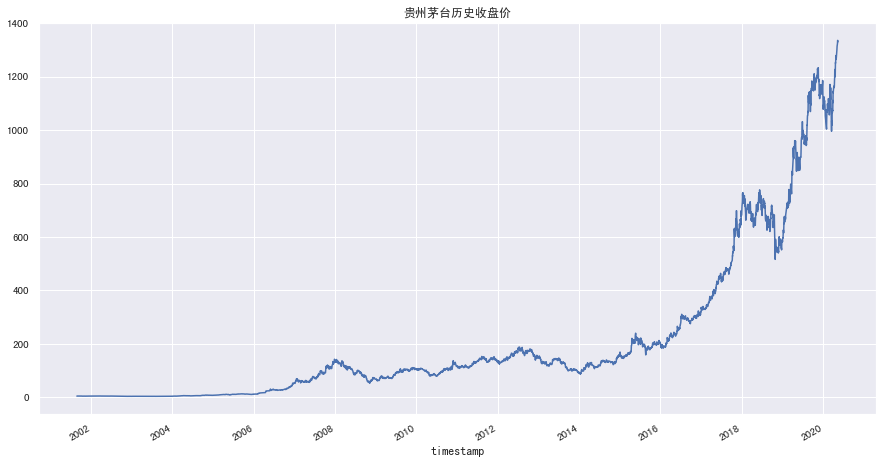

In [99]:
gzmt.plot(figsize=(15,8));
plt.title('贵州茅台历史收盘价');

### 重采样与频率转换


按照新的频率（更高频率、更低频率）对数据进行重采样，可以通过`resample()`方法、`asfreq()`方法。
1. `resample()`方法是以**数据累计**（data aggregation）为基础
2. `asfreq()`方法是以**数据选择**（data selection）为基础。

用两种方法对数据进行下采样（down-sample，减少采样频率，从日到月）。用每年末（`'BA'`，最后一个工作日）对数据进行重采样：

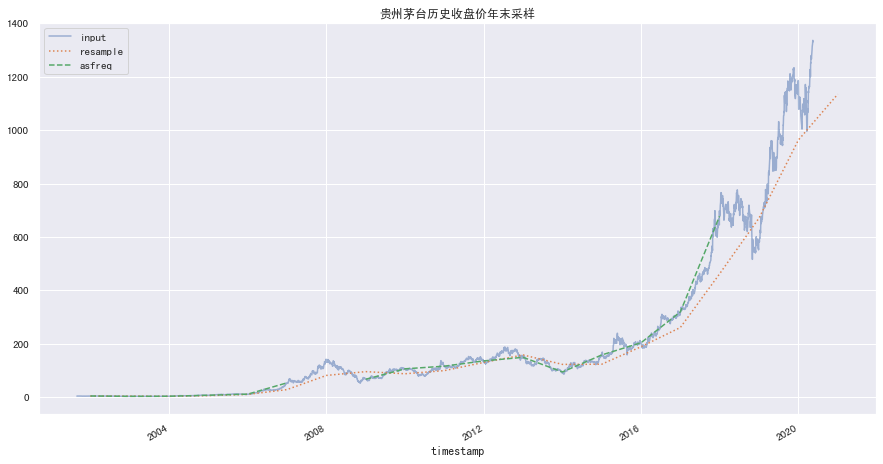

In [100]:
plt.figure(figsize=(15, 8))
gzmt.plot(alpha=0.5, style="-")
gzmt.resample("BA").mean().plot(style=":")
gzmt.asfreq("BA").plot(style="--")
plt.title('贵州茅台历史收盘价年末采样');
plt.legend(["input", "resample", "asfreq"], loc="upper left");

> 在每个数据点上，`resample`反映的是**上一年的均值**，而`asfreq`反映的是**上一年最后一个工作日的收盘价**。
>
> 在进行上采样（up-sampling，增加采样频率，从月到日）时，`resample()`与`asfreq()`的用法大体相同，

两种方法都默认将采样作为缺失值`NaN`，与`pd.fillna()`函数类似，`asfreq()`有一个`method`参数可以设置填充缺失值的方式。对数据按天进行重采样（包含周末），`asfreq()`向前填充与向后填充缺失值的结果对比：

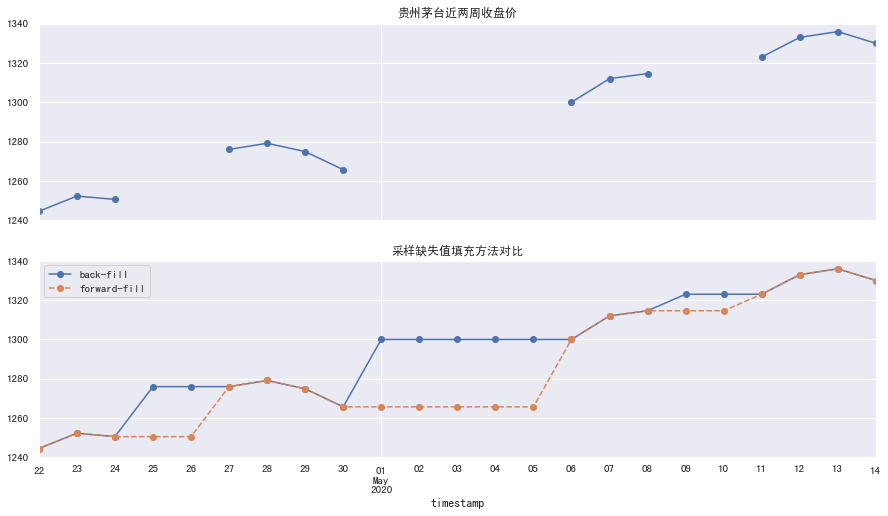

In [112]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15, 8))
data = gzmt.iloc[-14:]

ax[0].set_title("贵州茅台近两周收盘价")
data.asfreq("D").plot(ax=ax[0], marker="o")

ax[1].set_title("采样缺失值填充方法对比")

data.asfreq("D", method="bfill").plot(ax=ax[1], style="-o")
data.asfreq("D", method="ffill").plot(ax=ax[1], style="--o")
ax[1].legend(["back-fill", "forward-fill"]);

### 时间迁移

Pandas提供`shift()`方法**迁移数据**，`tshift()`方法**迁移索引**。两种方法都是按照频率代码进行迁移。

用`shift()`和`tshift()`这两种方法让数据迁移900天：
    

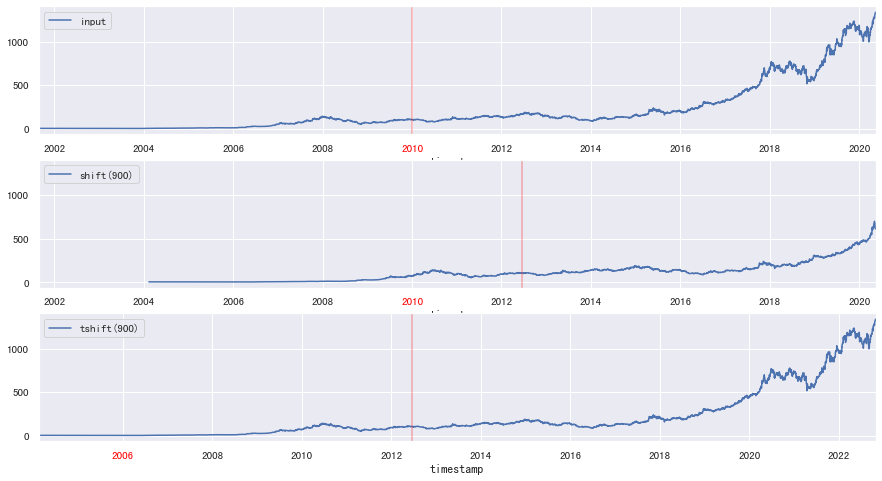

In [114]:
fig, ax = plt.subplots(3, sharey=True, figsize=(15, 8))

# 对数据应用时间频率，用向后填充解决缺失值
gzmt = gzmt.asfreq("D", method="pad")

gzmt.plot(ax=ax[0])
gzmt.shift(900).plot(ax=ax[1])
gzmt.tshift(900).plot(ax=ax[2])

# 设置图例与标签
local_max = pd.to_datetime("2010-01-01")
offset = pd.Timedelta(900, "D")

ax[0].legend(["input"], loc=2)
ax[0].get_xticklabels()[5].set(weight="heavy", color="red")
ax[0].axvline(local_max, alpha=0.3, color="red")

ax[1].legend(["shift(900)"], loc=2)
ax[1].get_xticklabels()[5].set(weight="heavy", color="red")
ax[1].axvline(local_max + offset, alpha=0.3, color="red")

ax[2].legend(["tshift(900)"], loc=2)
ax[2].get_xticklabels()[1].set(weight="heavy", color="red")
ax[2].axvline(local_max + offset, alpha=0.3, color="red");

> `shift(900)`将**数据**向前推进了900天，这样图形中的一段就消失了（最左侧就变成了缺失值），而`tshift(900)`方法是将**时间索引值**向前推进了900天。

可以用迁移后的值来计算gzmtle股票一年期的投资回报率：

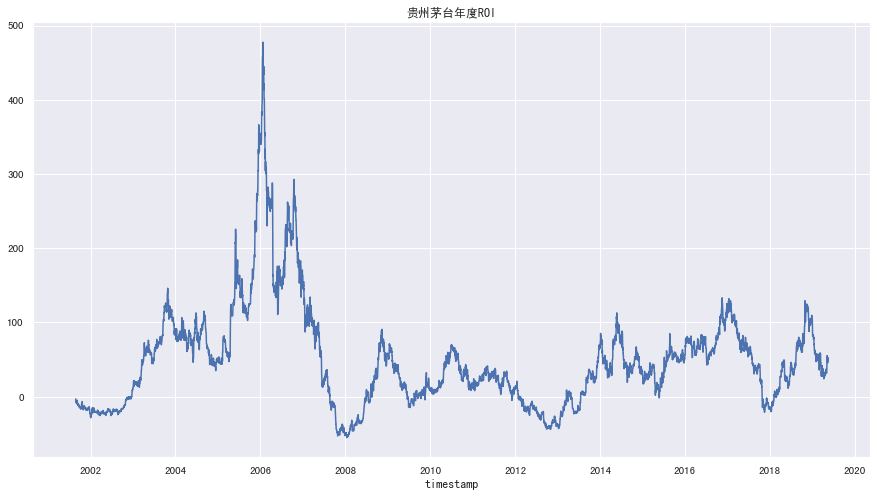

In [120]:
ROI = (gzmt.tshift(-365) / gzmt - 1) * 100

ROI.plot(figsize=(15, 8))
plt.title("贵州茅台年度ROI");

### 移动时间窗口

Pandas处理时间序列数据的第3种操作是移动统计值（rolling statistics）。通过`Series`和`DataFrame`的`rolling()`属性实现，它会返回与`groupby`操作类似的结果。

计算茅台股票收盘价的一年期移动平均值和标准差：

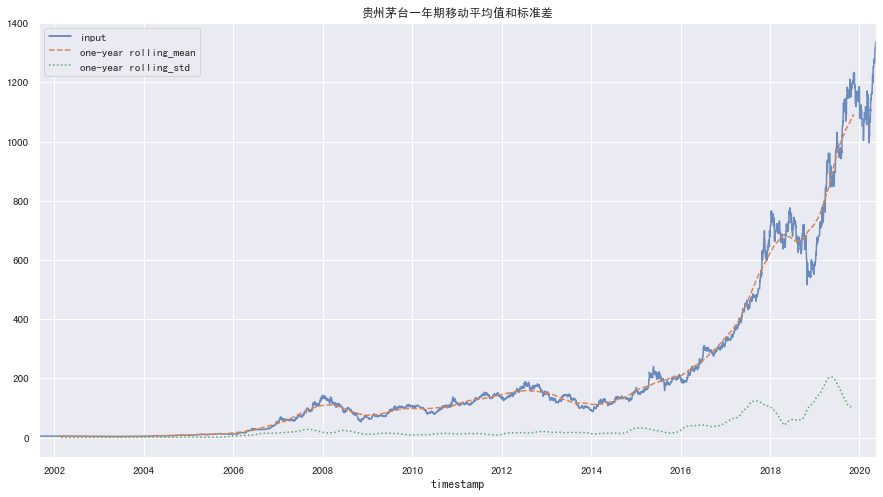

In [123]:
rolling = gzmt.rolling(365, center=True)

data = pd.DataFrame(
    {
        "input": gzmt,
        "one-year rolling_mean": rolling.mean(),
        "one-year rolling_std": rolling.std(),
    }
)
ax = data.plot(style=["-", "--", ":"], figsize=(15, 8))
ax.lines[0].set_alpha(0.8)
plt.title("贵州茅台一年期移动平均值和标准差");

## 高性能Pandas：`eval()`与`query()`

Pandas在处理复合代数式时（compound expression），每段中间过程都需要占用内存。Pandas从0.13版开始（2014年1月）基于[`Numexpr`](https://github.com/pydata/numexpr)程序包实现了`query()`与`eval()`，可以避免中间过程直接运算，借助NumPy风格的**字符串**实现，可以比普通方法快一倍（而且内存消耗更少）

In [124]:
nrows, ncols = 100000, 100
rng = np.random.RandomState(42)
df1, df2, df3, df4 = (pd.DataFrame(rng.rand(nrows, ncols)) for i in range(4))

In [125]:
%timeit df1 + df2 + df3 + df4

46.6 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [126]:
%timeit pd.eval('df1 + df2 + df3 + df4')

28.3 ms ± 424 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 算术运算符

`pd.eval()`支持所有的算术运算符：

In [127]:
result1 = -df1 * df2 / (df3 + df4)
result2 = pd.eval('-df1 * df2 / (df3 + df4)')
np.allclose(result1, result2)

True

### 比较运算符


`pd.eval()`支持所有的比较运算符，包括链式代数式（chained expression）：

In [128]:
result1 = (df1 < df2) & (df2 <= df3) & (df3 != df4)
result2 = pd.eval('df1 < df2 <= df3 != df4')
np.allclose(result1, result2)

True

### 位运算符

`pd.eval()`支持`&`（与）和`|`（或）等位运算符：

In [129]:
result1 = (df1 < 0.5) & (df2 < 0.5) | (df3 < df4)
result2 = pd.eval('(df1 < 0.5) & (df2 < 0.5) | (df3 < df4)')
np.allclose(result1, result2)

True

还可以在布尔类型的代数式中使用`and`和`or`：

In [130]:
result3 = pd.eval('(df1 < 0.5) and (df2 < 0.5) or (df3 < df4)')
np.allclose(result1, result3)

True

### 对象属性与索引

`pd.eval()`可以通过`obj.attr`语法获取对象属性，通过`obj[index]`语法获取对象索引：

In [131]:
result1 = df2.T[0] + df3.iloc[1]
result2 = pd.eval('df2.T[0] + df3.iloc[1]')
np.allclose(result1, result2)

True

### 用`DataFrame.eval()`实现列间运算

由于`pd.eval()`是Pandas的顶层函数，因此`DataFrame`有一个`eval()`方法可以做类似的运算。使用`eval()`方法的好处是可以借助**列名称**进行运算，示例如下：

In [133]:
df = pd.DataFrame(rng.rand(1000, 3), columns=["A", "B", "C"])
df.head()

,A,B,C
0,0.615875,0.525167,0.047354
1,0.330858,0.412879,0.441564
2,0.689047,0.559068,0.230350
3,0.290486,0.695479,0.852587
4,0.424280,0.534344,0.245216


In [134]:
result1 = (df['A'] + df['B']) / (df['C'] - 1)
result2 = pd.eval("(df.A + df.B) / (df.C - 1)")
np.allclose(result1, result2)

True

In [135]:
result3 = df.eval('(A + B) / (C - 1)')
np.allclose(result1, result3)

True

### 用`DataFrame.eval()`新增或修改列


除了前面介绍的运算功能，`DataFrame.eval()`还可以创建新的列，创建一个新的列`'D'`：

In [136]:
df.eval('D = (A + B) / C', inplace=True)
df.head()

,A,B,C,D
0,0.615875,0.525167,0.047354,24.095868
1,0.330858,0.412879,0.441564,1.684325
2,0.689047,0.559068,0.230350,5.418335
3,0.290486,0.695479,0.852587,1.156439
4,0.424280,0.534344,0.245216,3.909296


还可以修改已有的列：

In [137]:
df.eval('D = (A - B) / C', inplace=True)
df.head()

,A,B,C,D
0,0.615875,0.525167,0.047354,1.915527
1,0.330858,0.412879,0.441564,-0.185752
2,0.689047,0.559068,0.230350,0.564268
3,0.290486,0.695479,0.852587,-0.475016
4,0.424280,0.534344,0.245216,-0.448844


### `DataFrame.eval()`使用局部变量



`DataFrame.eval()`方法还支持通过`@`符号使用Python的局部变量，如下所示：   

In [138]:
column_mean = df.mean(1)
result1 = df['A'] + column_mean
result2 = df.eval('A + @column_mean')
np.allclose(result1, result2)

True

> `@`符号表示**变量名称**（Python对象的命名空间）而非**列名称**（DataFrame列名称的命名空间）。需要注意的是，`@`符号只能在`DataFrame.eval()`**方法**中使用，而不能在`pandas.eval()`**函数**中使用，因为`pandas.eval()`函数只能获取一个（Python）命名空间的内容。

### `DataFrame.query()`方法

用`query()`方法进行过滤运算：

In [139]:
result1 = df[(df.A < 0.5) & (df.B < 0.5)]
result2 = pd.eval('df[(df.A < 0.5) & (df.B < 0.5)]')
np.allclose(result1, result2)

True

In [140]:
result3 = df.query('A < 0.5 and B < 0.5')
np.allclose(result1, result3)

True

# Cython与Numba

## [Cython](http://cython.org/)

直接将Python代码编译成C/C++，然后编译成Python模块：

- 用Python代码调用原生C/C++
- 用静态类型声明让Python代码达到C语言的性能
- 代码变得更啰嗦，会破坏可维护性和可读性

<img src="2.data-elt/py_cy.png" width=800px></img>

In [1]:
%load_ext Cython

# %reload_ext Cython

In [2]:
%%cython

cdef int a = 0
for i in range(10):
    a += i
print(a)

45


1. 用Cython把`.pyx`文件编译（翻译）成`.c`文件。这些文件里的源代码，基本都是纯Python代码加上一些Cython代码
2. `.c`文件被C语言编译器编译成`.so`库，这个库之后可以导入Python
3. 编译代码有3种方法：
    1. 创建一个`distutils`模块配置文件，生成自定义的C语言编译文件。
    1. 运行`cython`命令将`.pyx`文件编译成`.c`文件，然后用C语言编译器（gcc）把C代码手动编译成库文件。
    1. 用`pyximport`，像导入`.py`文件一样导入`.pyx`直接使用。

## 创建Cython模块

In [3]:
%%bash
pwd
rm -rf test_cython
mkdir test_cython
ls

/home/junjiet/data_science2020/2.数据处理
2.数据处理.ipynb
cat_neural_network.mp4
cpp.ipynb
data2info.png
data_type.png
markmap.png
matlab_numpy.png
nn_flow.png
numpy.png
pandas.png
py_cy.png
pysparkdf.png
python_visual.png
rdd.png
sigmoid.png
social_network.jpg
test_cython
two_layer_nn.png


In [4]:
cd test_cython

/home/junjiet/data_science2020/2.数据处理/test_cython


In [5]:
pwd

'/home/junjiet/data_science2020/2.数据处理/test_cython'

In [6]:
%%file test.pyx

def join_n_print(parts):
    """merge string list with space"""
    print(' '.join(parts))

Writing test.pyx


In [26]:
ls

test.pyx


### pyximport自动编译

In [27]:
%%cython
import pyximport; pyximport.install()
from test_cython.test import join_n_print

join_n_print(["This", "is", "a", "test"])

This is a test


### setup.py手动编译

In [28]:
%%file setup.py

from distutils.core import setup
from Cython.Build import cythonize

setup(
    name="Test app", ext_modules=cythonize("test.pyx"),
)

Writing setup.py


In [36]:
!python setup.py build_ext --inplace

running build_ext


In [37]:
ls

build/  setup.py  test.c  test.cpython-37m-x86_64-linux-gnu.so*  test.pyx


In [41]:
!tree build/

build/
└── temp.linux-x86_64-3.7
    └── test.o

1 directory, 1 file


Cython通常都需要导入两类文件:

- **定义文件**：文件扩展名.pxd，是Cython文件要使用的变量、类型、函数名称的C语言声明。
- **实现文件**：文件扩展名.pyx，包括在`.pxd`文件中已经定义好的函数实现。

In [14]:
%%file dishes.pxd
cdef enum otherstuff:
    sausage, eggs, lettuce

cdef struct spamdish:
    int oz_of_spam
    otherstuff filler

Writing dishes.pxd


In [15]:
%%file restaurant.pyx
    
cimport dishes
from dishes cimport spamdish

cdef void prepare(spamdish * d):
    d.oz_of_spam = 42
    d.filler = dishes.sausage

def serve():
    cdef spamdish d
    prepare( & d)
    print(f"{d.oz_of_spam} oz spam, filler no. {d.filler}")

Writing restaurant.pyx


## 调用Cython模块

In [43]:
ls

build/  setup.py  test.c  test.cpython-37m-x86_64-linux-gnu.so*  test.pyx


In [44]:
from test_cython.test import join_n_print

join_n_print(["a", "b", "c"])

a b c


## 定义函数类型

Cython除了可以调用标准C语言函数，还可以定义两种函数：

- **标准Python函数**：与纯Python代码中声明的函数完全一样，用`cdef`关键字定义。接受Python对象作为参数，也返回Python对象
- **C函数**：是标准函数的优化版，用Python对象或C语言类型作为参数，返回值也可以是两种类型。要定义这种函数，用`cpdef`关键字定义

> 虽然这两种函数都可以通过Cython模块调用。但是从Python代码(.py)中调用函数，必须是标准Python函数，或者`cpdef`关键字定义函数。这个关键字会创建一个函数的封装对象。当用Cython调用函数时，它用C语言对象；当从Python代码中调用函数时，它用纯Python函数。

下面是一个纯Python函数，因此Cython会让这个函数返回并接收一个Python对象，而不是C语言原生类型。

In [45]:
%%cython

cdef full_python_function (x):
    return x**2

这个函数使用了`cpdef`关键字，所以它既是一个标准函数，也是一个优化过的C语言函数。

In [46]:
%%cython

cpdef int c_function(int x):
    return x**2

## 优化示例

两经纬度地理距离，A点经纬度（110.0123, 23.32435），B点经纬度（129.1344,25.5465）

### 纯Python

In [53]:
lon1, lat1, lon2, lat2 = 110.0123, 23.32435, 129.1344, 25.5465
num = 5000000

In [54]:
%%file great_circle_py.py
from math import pi, acos, cos, sin

def great_circle(lon1, lat1, lon2, lat2):
    radius = 6371  # 公里
    x = pi / 180

    a = (90 - lat1) * (x)
    b = (90 - lat2) * (x)
    theta = (lon2 - lon1) * (x)
    c = acos((cos(a) * cos(b)) + (sin(a) * sin(b) * cos(theta)))
    return radius * c

Overwriting great_circle_py.py


In [56]:
from great_circle_py import great_circle
for i in range(num):
    great_circle(lon1, lat1, lon2, lat2)

In [104]:
%%cython -a

from math import pi, acos, cos, sin


def great_circle(lon1, lat1, lon2, lat2):
    radius = 6371  # 公里
    x = pi / 180

    a = (90 - lat1) * (x)
    b = (90 - lat2) * (x)
    theta = (lon2 - lon1) * (x)
    c = acos((cos(a) * cos(b)) + (sin(a) * sin(b) * cos(theta)))
    return radius * c

building '_cython_magic_510139e97843e1ad4066ec2ca94da783' extension
/home/junjiet/conda/bin/x86_64-conda_cos6-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -Wstrict-prototypes -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/junjiet/conda/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/junjiet/conda/include -fPIC -I/home/junjiet/conda/include/python3.7m -c /home/junjiet/.cache/ipython/cython/_cython_magic_510139e97843e1ad4066ec2ca94da783.c -o /home/junjiet/.cache/ipython/cython/home/junjiet/.cache/ipython/cython/_cython_magic_510139e97843e1ad4066ec2ca94da783.o
x86_64-conda_cos6-linux-gnu-gcc -pthread -shared -Wl,-O2 -Wl,--sort-common -Wl,--as-needed -Wl,-z,relro -Wl,-z,now -Wl,-rpa

### Cython编译

In [60]:
%%file great_circle_cy_v1.pyx
from math import pi, acos, cos, sin

def great_circle(double lon1, double lat1, double lon2, double lat2):
    cdef double a, b, theta, c, x, radius
    
    radius = 6371  # 公里
    x = pi/180

    a = (90-lat1)*(x)
    b = (90-lat2)*(x)
    theta = (lon2-lon1)*(x)
    c = acos((cos(a)*cos(b)) + (sin(a)*sin(b)*cos(theta)))
    return radius*c

Writing great_circle_cy_v1.pyx


In [63]:
%%file great_circle_setup_v1.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    name='Great Circle module v1',
    ext_modules=cythonize("great_circle_cy_v1.pyx"),
)

Writing great_circle_setup_v1.py


In [64]:
!python great_circle_setup_v1.py build_ext --inplace

Compiling great_circle_cy_v1.pyx because it changed.
[1/1] Cythonizing great_circle_cy_v1.pyx
/home/junjiet/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/junjiet/data_science2020/2.数据处理/test_cython/great_circle_cy_v1.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'great_circle_cy_v1' extension
/home/junjiet/conda/bin/x86_64-conda_cos6-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -Wstrict-prototypes -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/junjiet/conda/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem

In [65]:
ls

build/
great_circle_cy_v1.c
great_circle_cy_v1.cpython-37m-x86_64-linux-gnu.so*
great_circle_cy_v1.pyx
great_circle_py.py
great_circle_setup_v1.py
__pycache__/
setup.py
test.c
test.cpython-37m-x86_64-linux-gnu.so*
test.pyx


In [68]:
from great_circle_cy_v1 import great_circle
for i in range(num):
    great_circle(lon1, lat1, lon2, lat2)

In [70]:
%%cython -a

from math import pi, acos, cos, sin

def great_circle(double lon1, double lat1, double lon2, double lat2):
    cdef double a, b, theta, c, x, radius
    
    radius = 6371  # 公里
    x = pi/180

    a = (90-lat1)*(x)
    b = (90-lat2)*(x)
    theta = (lon2-lon1)*(x)
    c = acos((cos(a)*cos(b)) + (sin(a)*sin(b)*cos(theta)))
    return radius*c

### C标准库函数

In [71]:
%%file great_circle_cy_v2.pyx
cdef extern from "math.h":
    float cosf(float theta)
    float sinf(float theta)
    float acosf(float theta)

cpdef double great_circle(double lon1, double lat1, double lon2, double lat2):
    cdef double a, b, theta, c, x, radius
    cdef double pi = 3.141592653589793

    radius = 6371  # 公里
    x = pi/180

    a = (90-lat1)*(x)
    b = (90-lat2)*(x)
    theta = (lon2-lon1)*(x)
    c = acosf((cosf(a)*cosf(b)) + (sinf(a)*sinf(b)*cosf(theta)))
    return radius*c

Writing great_circle_cy_v2.pyx


In [72]:
%%file great_circle_setup_v2.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    name="Great Circle module v2", ext_modules=cythonize("great_circle_cy_v2.pyx"),
)

Writing great_circle_setup_v2.py


In [73]:
!python great_circle_setup_v2.py build_ext --inplace

Compiling great_circle_cy_v2.pyx because it changed.
[1/1] Cythonizing great_circle_cy_v2.pyx
/home/junjiet/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/junjiet/data_science2020/2.数据处理/test_cython/great_circle_cy_v2.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'great_circle_cy_v2' extension
/home/junjiet/conda/bin/x86_64-conda_cos6-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -Wstrict-prototypes -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/junjiet/conda/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem

In [74]:
from great_circle_cy_v2 import great_circle
for i in range(num):
    great_circle(lon1, lat1, lon2, lat2)

In [76]:
%%cython -a

cdef extern from "math.h":
    float cosf(float theta)
    float sinf(float theta)
    float acosf(float theta)

cpdef double great_circle(double lon1, double lat1, double lon2, double lat2):
    cdef double a, b, theta, c, x, radius
    cdef double pi = 3.141592653589793

    radius = 6371  # 公里
    x = pi/180

    a = (90-lat1)*(x)
    b = (90-lat2)*(x)
    theta = (lon2-lon1)*(x)
    c = acosf((cosf(a)*cosf(b)) + (sinf(a)*sinf(b)*cosf(theta)))
    return radius*c

## [Numba](http://numba.pydata.org)

通过装饰器控制Python解释器把函数转变成机器码，实现了与C和Cython同样的性能，但是不需要用新的解释器或者写C代码。可以按需生成优化（JIT）的机器码，甚至可以编译成CPU或GPU可执行代码。

- JIT即时代码生成（On-the-fly code generation）
- CPU和GPU原生代码生成
- 与Numpy相关包交互

### `@jit`装饰器

In [79]:
a = np.random.rand(1000, 1000)

In [80]:
def sum2d(arr):
    M, N = arr.shape
    result = 0
    for i in range(M):
        for j in range(N):
            result += arr[i, j]
    return result

%timeit -r3 -n10 sum2d(a)

275 ms ± 13.1 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


#### 延迟编译（Lazy compilation）

In [81]:
from numba import jit

# jit装饰器告诉Numba编译函数，当函数被调用时，Numba再引入参数类型
@jit
def sum2d(arr):
    M, N = arr.shape
    result = 0
    for i in range(M):
        for j in range(N):
            result += arr[i, j]
    return result

%timeit sum2d(a)

1.28 ms ± 48.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


####  即时编译（Eager compilation）

由于python支持动态类型，因此`@jit`装饰器可以设置函数的接收类型（返回类型），按照配置参数进行优化，适合进行浮点数精度控制float32、float64。

In [82]:
from numba import jit, float64


@jit(float64(float64[:, :]))
def sum2d(arr):
    M, N = arr.shape
    result = 0
    for i in range(M):
        for j in range(N):
            result += arr[i, j]
    return result


%timeit sum2d(a)

949 µs ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


@jit配置函数签名的常用类型如下。

- `void`：函数返回值类型，表示不返回任何结果。
- `intp`和`uintp`：指针大小的整数，分别表示签名和无签名类型。
- `intc`和`uintc`：相当于C语言的整型和无符号整型。
- `int8`、`int16`、`int32`和`int64`：固定宽度整型（无符号整型前面加`u`，比如`uint8`）。
- `float32`和`float64`：单精度和双精度浮点数类型。
- `complex64`和`complex128`：单精度和双精度复数类型。
- 数组可以用任何带索引的数值类型表示，比如`float32[:]`就是一维浮点数数组类型，`int32[:,:]`就是二维整型数组。

### 编译选项

1. 非GIL模式：把`nogil=True`属性传到装饰器，就可以不受GIL的限制，多线程系统的常见问题（一致性、数据同步、竞态条件等）就可以解决。
1. [无Python模式](https://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#numba-troubleshooting)：可以通过`nopython`参数设置Numba的编译模式：
    1. `object`模式：默认模式，产生的代码可以处理所有Python对象，并用C API完成Python对象上的操作；
    1. `nopython`模式：可以不调用C API而生成更高效的代码，不过只有一部分函数和方法可以使用：
        - 函数中表示数值的所有原生类型都可以被引用
        - 函数中不可以分配新内存
1. 缓存模式：避免重复调用，通过`cache=True`将结果保证在缓存文件中
1. [并行模式](https://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel)：通过`parallel=True`并行计算，必须配合`nopython=True`使用

In [83]:
@jit(nopython=True)
def sum2d(arr):
    M, N = arr.shape
    result = 0
    for i in range(M):
        for j in range(N):
            result += arr[i, j]
    return result


%timeit sum2d(a)

962 µs ± 29.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [207]:
from numba import prange

@jit(parallel=True, nopython=True)
def sum2d(arr):
    M, N = arr.shape
    result = 0
    for i in prange(M):
        for j in range(N):
            result += arr[i, j]
    return result


%timeit sum2d(a)

1. @njit：@jit(nopython=True)的
1. @vectorize与@guvectorize：支持NumPy的通用函数（ufunc）
1. @stencil：定义一个核函数实现stencil（模版）类操作
1. @jitclass：jit编译python类
1. @cfunc：定义可以被C/C++直接调用的函数
1. @overload：注册一个在nopython模式使用自定义函数

# [pyspark](https://spark.apache.org/docs/latest/api/python/)

<img src="2.data-elt/spark_apply.png" width=800px></img>

## 安装

直接用connda安装即可，自动配置

```bash
conda install pyspark -c conda-forge
pip install findspark
```

## 初始化

In [1]:
import findspark

findspark.init(spark_home="/home/junjiet/conda/lib/python3.7/site-packages/pyspark")

from pyspark.sql import SparkSession, dataframe
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.sql import functions as F

sparkConf = SparkConf().set("spark.sql.execution.arrow.enabled", "false")
spark = SparkSession.builder.config(conf=sparkConf).enableHiveSupport().getOrCreate()
sc = SparkContext.getOrCreate()

## [RDD简介](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)

RDD(Resilient Distributed DataSet,弹性分布式数据集)，是Spark中最基本的数据抽象是，具有分区，不可变，并行操作特点

<img src="2.data-elt/rdd_compute.png" width=800px></img>

In [2]:
rdd = sc.parallelize([1, 2, 2, 3, 3, 4, 5])

### RDD常用转换(Transformation)API
<img src="2.data-elt/spark_transform_api.png" width=800px></img>

In [3]:
rdd.filter(lambda x: x % 2 == 0).collect()

[2, 2, 4]

### RDD常用动作(Action)API
<img src="2.data-elt/spark_action_api.png" width=800px></img>

In [4]:
rdd.count()

7

In [5]:
rdd.distinct().collect()

[1, 2, 3, 4, 5]

## RDD与DataFrame基本操作

![](2.data-elt/rdd.png)

![](2.data-elt/pysparkdf.png)

## Dataframe

In [6]:
schema = (
    StructType()
    .add("user_id", "string")
    .add("country", "string")
    .add("browser", "string")
    .add("OS", "string")
    .add("age", "integer")
    .add("salary", "double")
)

In [7]:
df = spark.createDataFrame(
    [
        ("A203", "India", "Chrome", "WIN", 33, 12.34),
        ("A201", "China", "Safari", "MacOS", 45, 14.56),
        ("A205", "UK", "Mozilla", "Linux", 25, 16.78),
        ("A206", "China", "Chrome", "MacOS", 68, 23.45),
    ],
    schema=schema,
)

df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- country: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- OS: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- salary: double (nullable = true)



In [8]:
df.show()

+-------+-------+-------+-----+---+------+
|user_id|country|browser|   OS|age|salary|
+-------+-------+-------+-----+---+------+
|   A203|  India| Chrome|  WIN| 33| 12.34|
|   A201|  China| Safari|MacOS| 45| 14.56|
|   A205|     UK|Mozilla|Linux| 25| 16.78|
|   A206|  China| Chrome|MacOS| 68| 23.45|
+-------+-------+-------+-----+---+------+



In [9]:
df.filter(df["age"] > 30)

DataFrame[user_id: string, country: string, browser: string, OS: string, age: int, salary: double]

In [10]:
df.filter(df["age"] > 30).count()

3

In [11]:
df.where((df["age"] > 30) & (df["country"] == "China")).show()

+-------+-------+-------+-----+---+------+
|user_id|country|browser|   OS|age|salary|
+-------+-------+-------+-----+---+------+
|   A201|  China| Safari|MacOS| 45| 14.56|
|   A206|  China| Chrome|MacOS| 68| 23.45|
+-------+-------+-------+-----+---+------+



In [12]:
df.toPandas()

,user_id,country,browser,OS,age,salary
0,A203,India,Chrome,WIN,33,12.34
1,A201,China,Safari,MacOS,45,14.56
2,A205,UK,Mozilla,Linux,25,16.78
3,A206,China,Chrome,MacOS,68,23.45


## 自定义函数

### DataFrame属性

In [13]:
from pyspark.sql import dataframe

def spark_shape(self):
    return (self.count(), len(self.columns))
dataframe.DataFrame.shape = spark_shape

In [14]:
df.shape()

(4, 6)

### UDF

In [15]:
from pyspark.sql.functions import udf


def age_category(age):
    if 18 <= age < 30:
        return "A"
    elif age < 60:
        return "B"
    else:
        return "C"


age_udf = udf(age_category, StringType())

df.withColumn("age_category", age_udf(df["age"])).show()

+-------+-------+-------+-----+---+------+------------+
|user_id|country|browser|   OS|age|salary|age_category|
+-------+-------+-------+-----+---+------+------------+
|   A203|  India| Chrome|  WIN| 33| 12.34|           B|
|   A201|  China| Safari|MacOS| 45| 14.56|           B|
|   A205|     UK|Mozilla|Linux| 25| 16.78|           A|
|   A206|  China| Chrome|MacOS| 68| 23.45|           C|
+-------+-------+-------+-----+---+------+------------+



### Pandas UDF

In [16]:
min_sal, max_sal = df.agg(F.min("salary"), F.max("salary")).collect()[0]
min_sal, max_sal

(12.34, 23.45)

In [18]:
from pyspark.sql.functions import pandas_udf

def scaled_salary(salary):
    scaled_sal = (salary - min_sal) / (max_sal - min_sal)
    return scaled_sal


scaling_udf = pandas_udf(scaled_salary, DoubleType())

In [21]:
df.select(df["salary"], scaling_udf(df["salary"])).show()

![](http://dblab.xmu.edu.cn/wp-content/themes/labstyle/images/branding.png)

1. [捕蛇者说](https://pythonhunter.org/) 中文python播客，有趣有料
1. [pandas_profiling](https://github.com/pandas-profiling/pandas-profiling) EDA可视化报表，支持导出html格式
2. [pandarallel](https://github.com/nalepae/pandarallel) CPU并行加速，apply、map、groupby与rolling等应用场景
3. [jax](https://github.com/google/jax) NumPy的GPU加速——谷歌开源，jakavdp参与开发
4. [cudf](https://github.com/rapidsai/cudf) Datafame的GPU加速
5. [koalas](https://koalas.readthedocs.io/en/latest/index.html) Databricks按照pandas实现的pyspark接口